In [10]:
import sys
sys.path.append('/home/fenglab/Desktop/transdiff_GRN/src/')

from find_modules import *
from topology import *

In [11]:
import seaborn as sns
from scipy import stats

random_s = 10
random.seed(random_s)

In [12]:
with open('./../data/count_matrix.csv', 'r') as f:
    lines = f.readlines()
entrez_ids = {line.split(',')[0]:line.split(',')[2] for line in lines[1:]}

with open('./../data/QuickGO-annotations-TFs.tsv', 'r') as f:
    lines = f.readlines()
tfs = [line.split('\t')[2] for line in lines[1:]]

with open('./../data/grn_expression.txt', 'r') as f:
    lines = f.readlines()
genes = [line.split('\t')[0] for line in lines[1:]]

grntfs = list(set(tfs)&set(genes))

In [13]:
treatments = ['Anp', 'AMn', 'AMp', 'AMnp']

In [14]:
DG = read_directed_grn(f'./../results/GRN/{treatments[0]}_7.txt')
DGp = remove_edge(DG, 0.49, component='positive')
print(f'edges {len(DGp.edges())}')
print(f'nodes {len(DGp.nodes())}')
print(f'''mean weight {np.sum([w for _, _, w in list(DGp.edges.data('weight'))])/len(DGp.edges())}''')
print(f'mean degree {np.sum(list(dict(DGp.degree()).values()))/len(DGp.nodes())}')

edges 523
nodes 192
mean weight 0.5643364081178456
mean degree 5.447916666666667


In [15]:
# x1, y1 = plot_degree(DGp, n_bins=20)
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(1, 1, 1)
# ax.loglog(x1,y1, 'o')

In [16]:
part_a = louvain_cluster(DGp, random_state=True, random_s=random_s)

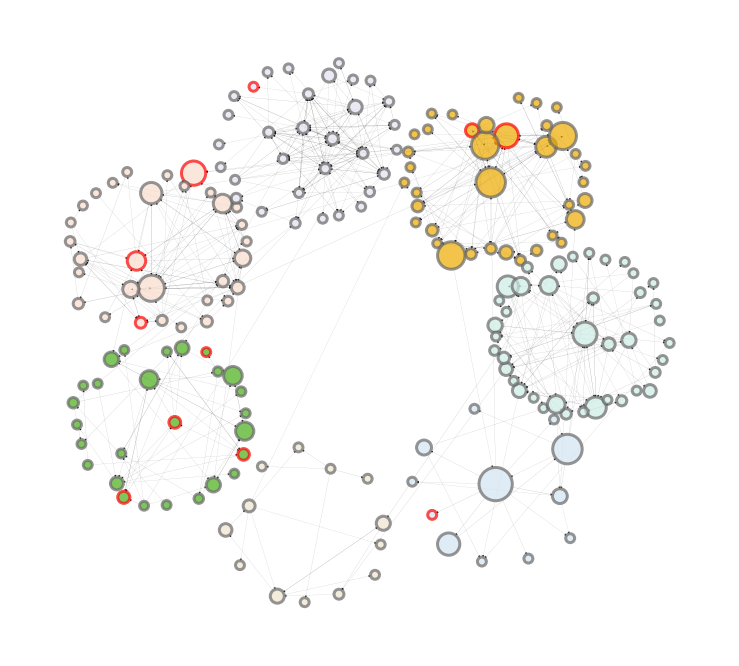

In [17]:
pos = community_layout(DGp, partition=part_a, scales_c=2.4, scales_n=1.8)
fig, ax = plt.subplots(figsize=(13, 12))
edge_colors = highlight_cmap(list(DGp.nodes()),grntfs)

node_size = np.array(list(nx.betweenness_centrality(DGp, seed=random_s).values()))*8000+80
edge_width = np.array(list(nx.get_edge_attributes(DGp, 'weight').values()))
#cmap = get_cmap(part_a, highlight=False)
cmap = get_cmap(part_a, highlight=True, modulelist=[1,4], alpha=0.8)
node_color=[cmap[v] for v in list(part_a.values())]

nodes = nx.draw_networkx_nodes(DGp, pos, node_color=node_color, edgecolors=edge_colors,
                               node_size=node_size, alpha=0.7, linewidths=3)
edges = nx.draw_networkx_edges(DGp, pos, node_size=node_size,
                               width=0.1*edge_width, edge_color='black', arrowsize=5)

ax.set_axis_off()
#plt.savefig('/home/fenglab/Downloads/Anet.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [18]:
pd.DataFrame(zip(list(DGp.nodes()), node_size), columns=['a', 'b']).sort_values(by='b', ascending=False)[:30]

,a,b
24,ADAMTS5,1107.429688
62,TRIM72,869.932280
10,CHRNB4,864.860628
83,PAG1,754.261045
28,CACNA1H,751.763178
15,CDHR1,737.649454
16,SMARCC1,686.265712
80,PRDM1,587.328006
31,PI15,578.076080
11,OTX2,573.533715
